# Trying to get learning of angles working, now with probabilities

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

from typing import Optional, Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import flax
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn
flax.config.update('flax_use_orbax_checkpointing', True)

from clu import parameter_overview

from typing import Any

from functools import partial

import tensorflow_datasets as tfds

from clu import deterministic_data
from clu import preprocess_spec
from clu import metrics

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.utils.preprocess import all_ops
from src.transformations import transform_image


PRNGKey = Any

2023-08-31 22:50:45.362931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
rng = random.PRNGKey(0)
train_data_rng, val_data_rng, init_rng, state_rng = random.split(rng, 4)

## Get data

In [3]:
ANGLE = 180

config = config_dict.ConfigDict()

config.batch_size = 512
config.dataset = "MNIST"
config.shuffle_buffer_size = 50_000
config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
config.train_split = f"train[10000:]"
config.pp_train = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image"])'
config.val_split = f"train[:10000]"
config.pp_eval = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image", "label"])'


config.model = config_dict.ConfigDict()
config.model.bounds = (0.25, 0.25, jnp.pi, 0.25, 0.25)
config.model.offset = (0.0, 0.0, 0.0, 0.0, 0.0)
config.model.inference = config_dict.ConfigDict()
config.model.inference.hidden_dims = (1024, 512, 256, 128)


In [4]:
def get_data(config):
    dataset_builder = tfds.builder(config.dataset)
    dataset_builder.download_and_prepare()

    local_batch_size  = config.batch_size // jax.device_count()

    train_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(config.train_split),
        # This RNG key will be used to derive all randomness in shuffling, data
        # preprocessing etc.
        rng=train_data_rng,
        shuffle_buffer_size=config.shuffle_buffer_size,
        # Depending on TPU/other runtime, local device count will be 8/1.
        batch_dims=[jax.local_device_count(), local_batch_size],
        repeat_after_batching=False,
        preprocess_fn=preprocess_spec.parse(
            spec=config.pp_train,
            available_ops=all_ops(),
        ),
        shuffle="loaded",
        )


    num_val_examples = dataset_builder.info.splits[config.val_split].num_examples
    # Compute how many batches we need to contain the entire val set.
    pad_up_to_batches = int(jnp.ceil(num_val_examples / config.batch_size))

    val_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(config.val_split),
        rng=val_data_rng,
        batch_dims=[jax.local_device_count(), local_batch_size],
        num_epochs=1,
        preprocess_fn=preprocess_spec.parse(
            spec=config.pp_eval,
            available_ops=all_ops(),
        ),
        # Pad with masked examples instead of dropping incomplete final batch.
        pad_up_to_batches=pad_up_to_batches,
        shuffle=False)

    return train_ds, val_ds

In [5]:
train_ds, val_ds = get_data(config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

## Setup TrainState and NN

In [6]:
@flax.struct.dataclass  # <-- required for JAX transformations
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')
    x_mse: metrics.Average.from_output('x_mse')

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics
    rng: PRNGKey
    λ: float
    λ_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    polyak_step_size: Optional[float] = None
    avg_params: Optional[flax.core.FrozenDict] = None

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)

        if self.polyak_step_size is not None:
            new_avg_params = optax.incremental_update(new_params, self.avg_params, self.polyak_step_size)
        else:
            new_avg_params = None

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            λ=self.λ_schedule(self.step),
            avg_params=new_avg_params,
            **kwargs,
        )

    @classmethod
    def create(
        cls,
        *,
        apply_fn,
        params,
        tx,
        λ_schedule,
        **kwargs,
    ):
        opt_state = tx.init(params)
        if kwargs.get("polyak_step_size", None) is not None:
            avg_params = params
        else:
            avg_params = None
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            λ_schedule=λ_schedule,
            λ=λ_schedule(0),
            avg_params=avg_params,
            **kwargs,
        )

def reset_metrics(state):
    return state.replace(metrics=state.metrics.empty())

In [7]:
from typing import Callable, Mapping, Optional, Sequence
from chex import Array, PRNGKey
import numpy as np
from flax.linen import initializers as init

KwArgs = Mapping[str, Any]

INV_SOFTPLUS_1 = jnp.log(jnp.exp(1) - 1.0)


def approximate_mode(
    distribution: distrax.Distribution, num_samples: int, rng: PRNGKey
) -> Array:
    """Approximates the mode of a distribution by taking a number of samples and returning the most likely.

    Args:
        distribution: A distribution.
        num_samples: The number of samples to take.
        rng: A PRNG key.

    Returns:
        An approximate mode.
    """
    samples, log_probs = distribution.sample_and_log_prob(
        seed=rng, sample_shape=(num_samples,)
    )
    return samples[jnp.argmax(log_probs)]


class TransformationInferenceNet(nn.Module):
    event_shape: Sequence[int]
    hidden_dims: Sequence[int]
    bounds_array: Array
    offset_array: Array
    σ_init: Callable = init.constant(jnp.log(jnp.exp(.01) - 1.0))

    @nn.compact
    def __call__(self, x, train: bool = True):
        h = x.flatten()

        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)
    
        output_dim = np.prod(self.event_shape)
        μ = nn.Dense(output_dim)(h)

        # return jax.nn.tanh(μ) * self.bounds_array

        # σ = jax.nn.softplus(nn.Dense(output_dim, name='σ_')(h)) 
        σ = jax.nn.softplus(self.param("σ_", self.σ_init, self.event_shape))

        # sample = distrax.Normal(loc=μ, scale=σ).sample(seed=self.make_rng('sample'))
        # return jax.nn.tanh(sample) * self.bounds_array

        base = distrax.Independent(
            distrax.Normal(loc=μ, scale=σ),
            len(self.event_shape)
        )

        bijector = distrax.Chain([
            distrax.Block(
                distrax.ScalarAffine(
                    shift=self.offset_array, scale=self.bounds_array
                ),
                len(self.event_shape)
            ),
            distrax.Block(distrax.Tanh(), len(self.event_shape)),
        ])
    
        return distrax.Transformed(base, bijector).sample(seed=self.make_rng('sample'))
    
    
class PrototypicalGenerativeModel(nn.Module):
    bounds: Sequence[int]
    offset: Optional[Sequence[int]] = None
    inference: Optional[KwArgs] = None

    def setup(self) -> None:
        self.bounds_array = jnp.array(self.bounds)
        self.offset_array = (
            jnp.array(self.offset)
            if self.offset is not None
            else jnp.zeros_like(self.bounds_array)
        )
        self.event_shape = self.bounds_array.shape
        self.inference_net = TransformationInferenceNet(
            event_shape=self.event_shape,
            bounds_array=self.bounds_array,
            offset_array=self.offset_array,
            **(self.inference or {}),
        )

    
    def __call__(self, x, train: bool = True):
        # dist = self.inference_net(x, train=train)

        # if train:
        #     return dist.sample(seed=rng)
        # else:
        #     return approximate_mode(dist, 1000, rng=rng)
        # return dist.sample(seed=rng)
        return self.inference_net(x, train=train)

In [8]:
model = PrototypicalGenerativeModel(**config.model.to_dict())

variables = model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+-------------------------------------+-------------+---------+-----------+--------+
| Name                                | Shape       | Size    | Mean      | Std    |
+-------------------------------------+-------------+---------+-----------+--------+
| params/inference_net/Dense_0/bias   | (1024,)     | 1,024   | 0.0       | 0.0    |
| params/inference_net/Dense_0/kernel | (784, 1024) | 802,816 | 8.62e-06  | 0.0357 |
| params/inference_net/Dense_1/bias   | (512,)      | 512     | 0.0       | 0.0    |
| params/inference_net/Dense_1/kernel | (1024, 512) | 524,288 | -7.33e-05 | 0.0313 |
| params/inference_net/Dense_2/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/inference_net/Dense_2/kernel | (512, 256)  | 131,072 | -4.57e-05 | 0.0441 |
| params/inference_net/Dense_3/bias   | (128,)      | 128     | 0.0       | 0.0    |
| params/inference_net/Dense_3/kernel | (256, 128)  | 32,768  | 8.77e-05  | 0.0624 |
| params/inference_net/Dense_4/bias   | (5,)        | 

## Self-supervised

In [9]:
TOTAL_STEPS = 10_000
LR = 1e-4
N_SAMPLES = 5
POLYAK_STEP_SIZE = None

params = flax.core.freeze(variables["params"])

def lr_schedule(init_lr, peak_mult, final_mult, peak_steps): 
    return optax.warmup_cosine_decay_schedule(
        init_lr, init_lr*peak_mult, peak_steps, TOTAL_STEPS, end_value=init_lr*final_mult
    )

def clipped_adamw(learning_rate, norm):
    return optax.MultiSteps(optax.chain(
        optax.clip_by_global_norm(norm),
        optax.adamw(learning_rate=learning_rate)
    ), 1)

# create a multi_transform which uses the above clipped adamw optimizer for all but the σ_ parameter,
# which uses a regular adam optimizer instead
from flax import traverse_util
partition_optimizers = {
    "params": optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
    "σ": optax.adam(lr_schedule(LR * 100, 3, 1/3, TOTAL_STEPS//10)),
}
param_partitions = flax.core.freeze(traverse_util.path_aware_map(
    lambda path, v: "σ" if "σ_" in path else "params", params
))
opt = optax.multi_transform(partition_optimizers, param_partitions)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    # tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
    tx=opt,
    metrics=Metrics.empty(),
    rng=state_rng,
    λ_schedule=optax.cosine_decay_schedule(1, TOTAL_STEPS, 1),
    polyak_step_size=POLYAK_STEP_SIZE,
)

In [10]:
def loss_fn(
    x, params, state, step_rng, train, n_samples,
):
    """Self-supervised loss function. 
    
    The loss can be summarised with the following diagram

            x ------- -η_x -----> x_hat
            |                       |
            |                       v
         η_rand                    mse
            |                       ∧
            ∨                       |
         x_rand --- -η_x_rand ---> x_hat'.

    However, implementing this directly requires doing 3 affine transformations, which adds 'blur' to the image.
    So instead we note that the diagram above is equivalent to

            x --------> mse <------- x'
            |                        ∧
            |                        |
         η_rand                     η_x
            |                        |
            v                        |
         x_rand --- -η_x_rand ---> x_hat'.

    Finally, this computation can be simplified to

            x --------> mse <-------- x'
            |                         ∧
            └ η_rand - η_x_rand + η_x ┘

    which contains only a single transformation.

    """
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    
    def per_sample_loss(rng):
        rng_sample1, rng_sample2, rng_η_rand, = random.split(rng, 3)

        η_x = state.apply_fn(
            {"params": params}, x, train, rngs={"sample": rng_sample1}
        )

        Η_rand = distrax.Uniform(
            low=-jnp.array(config.model.bounds),
            high=jnp.array(config.model.bounds)
        )
        η_rand = Η_rand.sample(seed=rng_η_rand, sample_shape=()) + jnp.array(config.model.offset)

        x_rand = transform_image(x, η_rand)
        η_x_rand = state.apply_fn(
            {"params": params}, x_rand, train, rngs={"sample": rng_sample2}
        )

        x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand + η_x)).mean()

        difficulty = optax.squared_error(x, x_rand).mean()

        return x_mse, difficulty
    
    rngs = random.split(rng_local, n_samples)
    x_mse, difficulty = jax.vmap(per_sample_loss)(rngs)
    
    # do a weighted average based on the difficulty of the sample
    weights = difficulty / difficulty.sum()
    x_mse, = jax.tree_map(lambda x: (x * weights).sum(axis=0), (x_mse,))
    loss = x_mse

    return loss, {"loss": loss, "x_mse": x_mse}

In [11]:
@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True, N_SAMPLES,
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    # logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr", state.opt_state.inner_states['params'][0].hyperparams["learning_rate"])
    logs.add_entry("gradients", "grad_norm", optax.global_norm(grads))

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False, 1
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.params if state.avg_params is None else state.avg_params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [12]:
state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS),
        # ciclo.early_stopping("loss_test", patience=TOTAL_STEPS // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=TOTAL_STEPS + 1,
)

INFO:absl:Saving checkpoint at step: -0.45680514
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.45680513978004456.
INFO:absl:Renaming checkpoint/checkpoint_-0.45680513978004456.orbax-checkpoint-tmp-1693518673949249 to checkpoint/checkpoint_-0.45680513978004456
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.45680513978004456`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.1966547667980194


   98/10000 [..............................] - ETA: 22:07 - loss: 0.3805 - x_mse: 0.3805 - loss_test: 0.4568 - x_mse_test: 0.4568

INFO:absl:Saving checkpoint at step: -0.33957806
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.3395780622959137.
INFO:absl:Renaming checkpoint/checkpoint_-0.3395780622959137.orbax-checkpoint-tmp-1693518676205787 to checkpoint/checkpoint_-0.3395780622959137
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.3395780622959137`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.45680513978004456


  197/10000 [..............................] - ETA: 12:22 - loss: 0.3287 - x_mse: 0.3287 - loss_test: 0.3396 - x_mse_test: 0.3396

INFO:absl:Saving checkpoint at step: -0.3087315
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.3087314963340759.
INFO:absl:Renaming checkpoint/checkpoint_-0.3087314963340759.orbax-checkpoint-tmp-1693518677981371 to checkpoint/checkpoint_-0.3087314963340759
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.3087314963340759`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.3395780622959137


  296/10000 [..............................] - ETA: 9:06 - loss: 0.3129 - x_mse: 0.3129 - loss_test: 0.3087 - x_mse_test: 0.3087

INFO:absl:Saving checkpoint at step: -0.2973385
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.29733848571777344.
INFO:absl:Renaming checkpoint/checkpoint_-0.29733848571777344.orbax-checkpoint-tmp-1693518679763070 to checkpoint/checkpoint_-0.29733848571777344
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.29733848571777344`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.3087314963340759


  499/10000 [>.............................] - ETA: 6:24 - loss: 0.2963 - x_mse: 0.2963 - loss_test: 0.3007 - x_mse_test: 0.3007

INFO:absl:Saving checkpoint at step: -0.29156324
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2915632426738739.
INFO:absl:Renaming checkpoint/checkpoint_-0.2915632426738739.orbax-checkpoint-tmp-1693518683288704 to checkpoint/checkpoint_-0.2915632426738739
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2915632426738739`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.29733848571777344


  596/10000 [>.............................] - ETA: 5:46 - loss: 0.2945 - x_mse: 0.2945 - loss_test: 0.2916 - x_mse_test: 0.2916

INFO:absl:Saving checkpoint at step: -0.28582048
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.28582048416137695.
INFO:absl:Renaming checkpoint/checkpoint_-0.28582048416137695.orbax-checkpoint-tmp-1693518685073941 to checkpoint/checkpoint_-0.28582048416137695
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.28582048416137695`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2915632426738739


  797/10000 [=>............................] - ETA: 4:52 - loss: 0.2882 - x_mse: 0.2882 - loss_test: 0.2873 - x_mse_test: 0.2873

INFO:absl:Saving checkpoint at step: -0.27945983
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2794598340988159.
INFO:absl:Renaming checkpoint/checkpoint_-0.2794598340988159.orbax-checkpoint-tmp-1693518688413942 to checkpoint/checkpoint_-0.2794598340988159
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2794598340988159`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.28582048416137695


  896/10000 [=>............................] - ETA: 4:35 - loss: 0.2908 - x_mse: 0.2908 - loss_test: 0.2795 - x_mse_test: 0.2795

INFO:absl:Saving checkpoint at step: -0.27687055
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2768705487251282.
INFO:absl:Renaming checkpoint/checkpoint_-0.2768705487251282.orbax-checkpoint-tmp-1693518690168404 to checkpoint/checkpoint_-0.2768705487251282
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2768705487251282`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2794598340988159


 1198/10000 [==>...........................] - ETA: 3:57 - loss: 0.2833 - x_mse: 0.2833 - loss_test: 0.2886 - x_mse_test: 0.2886

INFO:absl:Saving checkpoint at step: -0.27463052
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.27463051676750183.
INFO:absl:Renaming checkpoint/checkpoint_-0.27463051676750183.orbax-checkpoint-tmp-1693518695328100 to checkpoint/checkpoint_-0.27463051676750183
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.27463051676750183`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2768705487251282


 1898/10000 [====>.........................] - ETA: 3:13 - loss: 0.2744 - x_mse: 0.2744 - loss_test: 0.2787 - x_mse_test: 0.2787

INFO:absl:Saving checkpoint at step: -0.27029473
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.270294725894928.
INFO:absl:Renaming checkpoint/checkpoint_-0.270294725894928.orbax-checkpoint-tmp-1693518708501315 to checkpoint/checkpoint_-0.270294725894928
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.270294725894928`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.27463051676750183


 1997/10000 [====>.........................] - ETA: 3:09 - loss: 0.2727 - x_mse: 0.2727 - loss_test: 0.2703 - x_mse_test: 0.2703

INFO:absl:Saving checkpoint at step: -0.26201364
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.26201364398002625.
INFO:absl:Renaming checkpoint/checkpoint_-0.26201364398002625.orbax-checkpoint-tmp-1693518710465996 to checkpoint/checkpoint_-0.26201364398002625
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.26201364398002625`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.270294725894928


 2796/10000 [=======>......................] - ETA: 2:37 - loss: 0.2637 - x_mse: 0.2637 - loss_test: 0.2642 - x_mse_test: 0.2642

INFO:absl:Saving checkpoint at step: -0.26040423
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.26040422916412354.
INFO:absl:Renaming checkpoint/checkpoint_-0.26040422916412354.orbax-checkpoint-tmp-1693518724129341 to checkpoint/checkpoint_-0.26040422916412354
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.26040422916412354`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.26201364398002625


 2996/10000 [=======>......................] - ETA: 2:31 - loss: 0.2584 - x_mse: 0.2584 - loss_test: 0.2628 - x_mse_test: 0.2628

INFO:absl:Saving checkpoint at step: -0.25512654
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2551265358924866.
INFO:absl:Renaming checkpoint/checkpoint_-0.2551265358924866.orbax-checkpoint-tmp-1693518727740269 to checkpoint/checkpoint_-0.2551265358924866
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2551265358924866`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.26040422916412354


 3096/10000 [========>.....................] - ETA: 2:28 - loss: 0.2537 - x_mse: 0.2537 - loss_test: 0.2551 - x_mse_test: 0.2551

INFO:absl:Saving checkpoint at step: -0.2467475
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.24674749374389648.
INFO:absl:Renaming checkpoint/checkpoint_-0.24674749374389648.orbax-checkpoint-tmp-1693518729644454 to checkpoint/checkpoint_-0.24674749374389648
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.24674749374389648`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2551265358924866


 3296/10000 [========>.....................] - ETA: 2:22 - loss: 0.2438 - x_mse: 0.2438 - loss_test: 0.2471 - x_mse_test: 0.2471

INFO:absl:Saving checkpoint at step: -0.24448621
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.24448621273040771.
INFO:absl:Renaming checkpoint/checkpoint_-0.24448621273040771.orbax-checkpoint-tmp-1693518733007419 to checkpoint/checkpoint_-0.24448621273040771
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.24448621273040771`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.24674749374389648


 3396/10000 [=========>....................] - ETA: 2:19 - loss: 0.2421 - x_mse: 0.2421 - loss_test: 0.2445 - x_mse_test: 0.2445

INFO:absl:Saving checkpoint at step: -0.24027283
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.24027283489704132.
INFO:absl:Renaming checkpoint/checkpoint_-0.24027283489704132.orbax-checkpoint-tmp-1693518734749764 to checkpoint/checkpoint_-0.24027283489704132
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.24027283489704132`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.24448621273040771


 3499/10000 [=========>....................] - ETA: 2:16 - loss: 0.2377 - x_mse: 0.2377 - loss_test: 0.2403 - x_mse_test: 0.2403

INFO:absl:Saving checkpoint at step: -0.23002367
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.23002366721630096.
INFO:absl:Renaming checkpoint/checkpoint_-0.23002366721630096.orbax-checkpoint-tmp-1693518736533159 to checkpoint/checkpoint_-0.23002366721630096
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.23002366721630096`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.24027283489704132


 3996/10000 [==========>...................] - ETA: 2:02 - loss: 0.2310 - x_mse: 0.2310 - loss_test: 0.2314 - x_mse_test: 0.2314

INFO:absl:Saving checkpoint at step: -0.22702381
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.22702381014823914.
INFO:absl:Renaming checkpoint/checkpoint_-0.22702381014823914.orbax-checkpoint-tmp-1693518744806138 to checkpoint/checkpoint_-0.22702381014823914
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.22702381014823914`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.23002366721630096


 4096/10000 [===========>..................] - ETA: 2:00 - loss: 0.2322 - x_mse: 0.2322 - loss_test: 0.2270 - x_mse_test: 0.2270

INFO:absl:Saving checkpoint at step: -0.22476462
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2247646152973175.
INFO:absl:Renaming checkpoint/checkpoint_-0.2247646152973175.orbax-checkpoint-tmp-1693518746588720 to checkpoint/checkpoint_-0.2247646152973175
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2247646152973175`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.22702381014823914


 4296/10000 [===========>..................] - ETA: 1:55 - loss: 0.2270 - x_mse: 0.2270 - loss_test: 0.2272 - x_mse_test: 0.2272

INFO:absl:Saving checkpoint at step: -0.22296456
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2229645550251007.
INFO:absl:Renaming checkpoint/checkpoint_-0.2229645550251007.orbax-checkpoint-tmp-1693518750062820 to checkpoint/checkpoint_-0.2229645550251007
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2229645550251007`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2247646152973175


 4496/10000 [============>.................] - ETA: 1:50 - loss: 0.2229 - x_mse: 0.2229 - loss_test: 0.2238 - x_mse_test: 0.2238

INFO:absl:Saving checkpoint at step: -0.22058979
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2205897867679596.
INFO:absl:Renaming checkpoint/checkpoint_-0.2205897867679596.orbax-checkpoint-tmp-1693518753419403 to checkpoint/checkpoint_-0.2205897867679596
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2205897867679596`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2229645550251007


 4596/10000 [============>.................] - ETA: 1:48 - loss: 0.2216 - x_mse: 0.2216 - loss_test: 0.2206 - x_mse_test: 0.2206

INFO:absl:Saving checkpoint at step: -0.21670301
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.21670301258563995.
INFO:absl:Renaming checkpoint/checkpoint_-0.21670301258563995.orbax-checkpoint-tmp-1693518755211195 to checkpoint/checkpoint_-0.21670301258563995
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.21670301258563995`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2205897867679596


 4696/10000 [=============>................] - ETA: 1:46 - loss: 0.2238 - x_mse: 0.2238 - loss_test: 0.2167 - x_mse_test: 0.2167

INFO:absl:Saving checkpoint at step: -0.21461199
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2146119922399521.
INFO:absl:Renaming checkpoint/checkpoint_-0.2146119922399521.orbax-checkpoint-tmp-1693518757008558 to checkpoint/checkpoint_-0.2146119922399521
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2146119922399521`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.21670301258563995


 5096/10000 [==============>...............] - ETA: 1:36 - loss: 0.2172 - x_mse: 0.2172 - loss_test: 0.2193 - x_mse_test: 0.2193

INFO:absl:Saving checkpoint at step: -0.2122025
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2122025042772293.
INFO:absl:Renaming checkpoint/checkpoint_-0.2122025042772293.orbax-checkpoint-tmp-1693518763663068 to checkpoint/checkpoint_-0.2122025042772293
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2122025042772293`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2146119922399521


 5499/10000 [===============>..............] - ETA: 1:27 - loss: 0.2143 - x_mse: 0.2143 - loss_test: 0.2149 - x_mse_test: 0.2149

INFO:absl:Saving checkpoint at step: -0.21145774
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2114577442407608.
INFO:absl:Renaming checkpoint/checkpoint_-0.2114577442407608.orbax-checkpoint-tmp-1693518770381188 to checkpoint/checkpoint_-0.2114577442407608
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2114577442407608`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2122025042772293


 6096/10000 [=================>............] - ETA: 1:14 - loss: 0.2122 - x_mse: 0.2122 - loss_test: 0.2141 - x_mse_test: 0.2141

INFO:absl:Saving checkpoint at step: -0.2104485
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2104485034942627.
INFO:absl:Renaming checkpoint/checkpoint_-0.2104485034942627.orbax-checkpoint-tmp-1693518780154404 to checkpoint/checkpoint_-0.2104485034942627
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2104485034942627`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2114577442407608


 6297/10000 [=================>............] - ETA: 1:10 - loss: 0.2115 - x_mse: 0.2115 - loss_test: 0.2141 - x_mse_test: 0.2141

INFO:absl:Saving checkpoint at step: -0.20682542
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.20682542026042938.
INFO:absl:Renaming checkpoint/checkpoint_-0.20682542026042938.orbax-checkpoint-tmp-1693518783574530 to checkpoint/checkpoint_-0.20682542026042938
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.20682542026042938`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2104485034942627


 6396/10000 [==================>...........] - ETA: 1:08 - loss: 0.2111 - x_mse: 0.2111 - loss_test: 0.2068 - x_mse_test: 0.2068

INFO:absl:Saving checkpoint at step: -0.20666924
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.20666924118995667.
INFO:absl:Renaming checkpoint/checkpoint_-0.20666924118995667.orbax-checkpoint-tmp-1693518785355480 to checkpoint/checkpoint_-0.20666924118995667
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.20666924118995667`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.20682542026042938


 6496/10000 [==================>...........] - ETA: 1:06 - loss: 0.2087 - x_mse: 0.2087 - loss_test: 0.2067 - x_mse_test: 0.2067

INFO:absl:Saving checkpoint at step: -0.20399596
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2039959579706192.
INFO:absl:Renaming checkpoint/checkpoint_-0.2039959579706192.orbax-checkpoint-tmp-1693518787126189 to checkpoint/checkpoint_-0.2039959579706192
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2039959579706192`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.20666924118995667


 6996/10000 [===================>..........] - ETA: 56s - loss: 0.2069 - x_mse: 0.2069 - loss_test: 0.2090 - x_mse_test: 0.2090

INFO:absl:Saving checkpoint at step: -0.2012788
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.20127880573272705.
INFO:absl:Renaming checkpoint/checkpoint_-0.20127880573272705.orbax-checkpoint-tmp-1693518795387670 to checkpoint/checkpoint_-0.20127880573272705
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.20127880573272705`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2039959579706192


 7396/10000 [=====================>........] - ETA: 48s - loss: 0.2052 - x_mse: 0.2052 - loss_test: 0.2017 - x_mse_test: 0.2017

INFO:absl:Saving checkpoint at step: -0.19952962
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19952961802482605.
INFO:absl:Renaming checkpoint/checkpoint_-0.19952961802482605.orbax-checkpoint-tmp-1693518802156804 to checkpoint/checkpoint_-0.19952961802482605
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19952961802482605`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.20127880573272705


 7696/10000 [======================>.......] - ETA: 43s - loss: 0.2033 - x_mse: 0.2033 - loss_test: 0.2008 - x_mse_test: 0.2008

INFO:absl:Saving checkpoint at step: -0.1979414
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.197941392660141.
INFO:absl:Renaming checkpoint/checkpoint_-0.197941392660141.orbax-checkpoint-tmp-1693518807237225 to checkpoint/checkpoint_-0.197941392660141
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.197941392660141`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19952961802482605


 7996/10000 [======================>.......] - ETA: 37s - loss: 0.2023 - x_mse: 0.2023 - loss_test: 0.2034 - x_mse_test: 0.2034

INFO:absl:Saving checkpoint at step: -0.19792165
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19792164862155914.
INFO:absl:Renaming checkpoint/checkpoint_-0.19792164862155914.orbax-checkpoint-tmp-1693518812312673 to checkpoint/checkpoint_-0.19792164862155914
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19792164862155914`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.197941392660141


 8496/10000 [========================>.....] - ETA: 27s - loss: 0.2004 - x_mse: 0.2004 - loss_test: 0.1981 - x_mse_test: 0.1981

INFO:absl:Saving checkpoint at step: -0.19728811
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19728811085224152.
INFO:absl:Renaming checkpoint/checkpoint_-0.19728811085224152.orbax-checkpoint-tmp-1693518820562992 to checkpoint/checkpoint_-0.19728811085224152
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19728811085224152`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19792164862155914


 8796/10000 [=========================>....] - ETA: 22s - loss: 0.1994 - x_mse: 0.1994 - loss_test: 0.1991 - x_mse_test: 0.1991

INFO:absl:Saving checkpoint at step: -0.19704777
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19704777002334595.
INFO:absl:Renaming checkpoint/checkpoint_-0.19704777002334595.orbax-checkpoint-tmp-1693518825561603 to checkpoint/checkpoint_-0.19704777002334595
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19704777002334595`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19728811085224152


 9696/10000 [============================>.] - ETA: 5s - loss: 0.1976 - x_mse: 0.1976 - loss_test: 0.1973 - x_mse_test: 0.1973

INFO:absl:Saving checkpoint at step: -0.19665477
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.1966547667980194.
INFO:absl:Renaming checkpoint/checkpoint_-0.1966547667980194.orbax-checkpoint-tmp-1693518840674797 to checkpoint/checkpoint_-0.1966547667980194
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.1966547667980194`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19704777002334595


10000/10000 [==============================] - 183s 18ms/step - loss: 0.1976 - x_mse: 0.1976 - loss_test: 0.2004 - x_mse_test: 0.2004


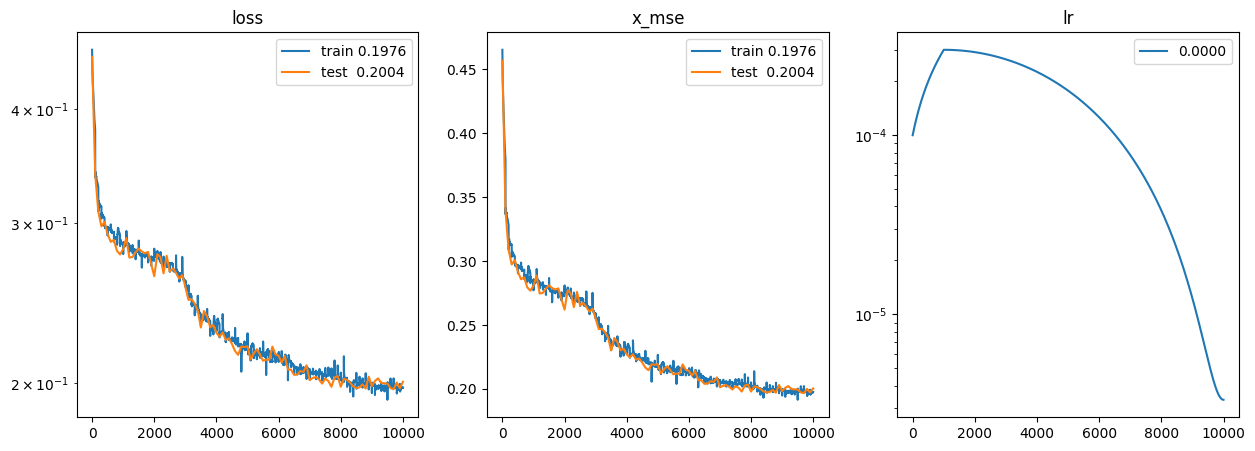

In [13]:
# plot the training history
steps, loss, x_mse, λ, lr, grad_norm = history.collect(
    "steps", "loss", "x_mse", "λ", "lr", "grad_norm"
)
steps_test, loss_test, x_mse_test = history.collect(
    "steps", "loss_test", "x_mse_test"
)

n_plots = 3
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")
axs[0].set_yscale("log")

axs[1].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[1].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("x_mse")

axs[2].plot(steps, lr, label=f"{lr[-1]:.4f}")
axs[2].legend()
axs[2].set_title("lr")
axs[2].set_yscale("log")

plt.show()

In [14]:
# load the best model using flax checkpointing
from flax.training import checkpoints

best_state = checkpoints.restore_checkpoint(ckpt_dir='checkpoint', target=state)
best_state.step

INFO:absl:Restoring orbax checkpoint from checkpoint/checkpoint_-0.1966547667980194
INFO:absl:Restoring item from checkpoint/checkpoint_-0.1966547667980194.
INFO:absl:Finished restoring checkpoint from checkpoint/checkpoint_-0.1966547667980194.


Array(9701, dtype=int32)

In [15]:
jax.nn.softplus(best_state.params['inference_net']['σ_']).mean()

Array(0.00010842, dtype=float32)

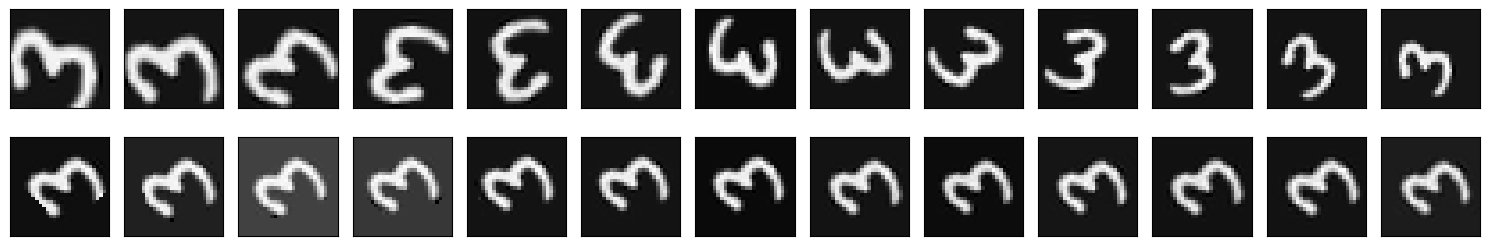

In [16]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

def get_proto(x):
    η = best_state.apply_fn({"params": best_state.avg_params if best_state.avg_params is not None else best_state.params},
                            x, train=False, rngs={"sample": rng})
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
        x_,
        jnp.linspace(-jnp.array(config.model.bounds) * mask, jnp.array(config.model.bounds) * mask, 13)
    )

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(x, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(xhat, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

[]

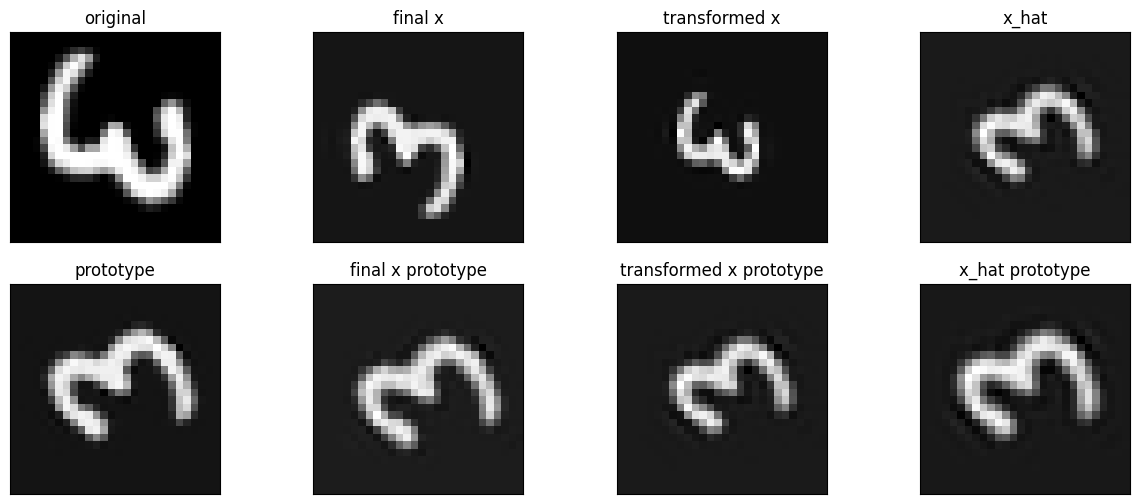

In [17]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(config.model.bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
